In [18]:
import torch
import torch.nn as nn
import numpy as np
from data_process import get_data_loaders, getFeatures
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

## Flight Data

In [19]:
data = pd.read_csv('flights.csv')
data.head()

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
0,1,0.0,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,0.006815,0.004258,-0.120405,-9.811137,4.0,0.0,25,2019-04-07,10:13,R5
1,1,0.2,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,0.002034,0.006175,-0.116397,-9.810392,4.0,0.0,25,2019-04-07,10:13,R5
2,1,0.3,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,-0.000874,0.002696,-0.128592,-9.809440,4.0,0.0,25,2019-04-07,10:13,R5
3,1,0.5,0.1,354.0,24.224678,0.095421,-79.782396,40.458047,269.334648,0.001775,...,0.002443,0.002024,-0.128271,-9.810159,4.0,0.0,25,2019-04-07,10:13,R5
4,1,0.6,0.1,359.0,24.210905,0.079518,-79.782396,40.458047,269.336178,0.001775,...,-0.006425,0.008271,-0.119890,-9.812125,4.0,0.0,25,2019-04-07,10:13,R5


<Axes: title={'center': 'Flight 1'}, xlabel='position_x'>

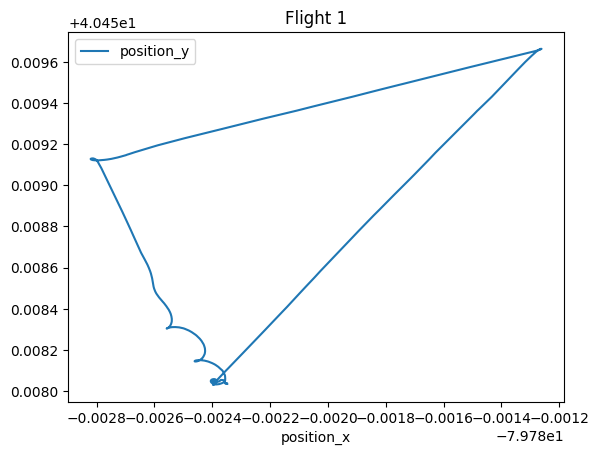

In [20]:
flight_data = data[data['flight']==1]
flight_data.plot(x='position_x', y='position_y', title='Flight 1')

We aim to predict future power in a sequence. From the engineering perspective, the future power can be related with future controls such as the acceleration. Then in this case, we consider power prediction under two scenarios: one is that we have no infomation from future, so predict the future based on current and histroic features; the other is to, beyond that, take the future trajectories as the covariates for prediciton, assuming that the mobility follows the trajectory which is usually the case when vehicle follows the navigation.

## Scenarios without covariates

### Create data loader of sequence to sequence (without Covariates)

In [21]:
# Specify the input sequence length and output sequence length
input_len, output_len = 20, 10

In [22]:
# Get all potential features of the dataloader
all_features = getFeatures(covariates=False)

# Specify the features to be used
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']

In [23]:
data, train_loader, val_loader, test_loader, d_split, scaler = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                                features=select_features, covariates=False)

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']


### Models (without covariates)

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [86]:
# Model parameters
encoder_input_size = len(select_features)
decoder_input_size = encoder_input_size
hidden_size = 32  
num_layers = 1

#### LSTM-LSTM

In [87]:
from model.LSTM_LSTM import LSTM_LSTM

lstm_lstm = LSTM_LSTM(encoder_input_size, decoder_input_size, input_len, output_len, hidden_size, num_layers=num_layers).to(device)

pytorch_total_params = sum(p.numel() for p in lstm_lstm.parameters() if p.requires_grad)
print(pytorch_total_params)

10727


In [88]:
# Load saved model
lstm_lstm.load_state_dict(torch.load(f'saved_model/LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt'))

<All keys matched successfully>

#### TCN-LSTM

In [94]:
from model.TCN_LSTM import TCN_LSTM

tcn_lstm = TCN_LSTM(encoder_input_size, decoder_input_size, input_len, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)

pytorch_total_params = sum(p.numel() for p in tcn_lstm.parameters() if p.requires_grad)
print(pytorch_total_params)

13660


In [95]:
# Load saved model
tcn_lstm.load_state_dict(torch.load(f'saved_model/TCN_LSTM_select_best_model_{input_len}-{output_len}.pt'))

<All keys matched successfully>

### Test the model

In [96]:

for seq2seq in [lstm_lstm, tcn_lstm]:

    seq2seq.eval()
    mape_list = []
    sum_mape = 0
    sum_size = 0
    r2_score_list = np.array([])
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = seq2seq(inputs)  
            outputs = outputs.squeeze(-1)

        # print(r2_score(targets.cpu().T, outputs.cpu().T, multioutput='raw_values').shape)
    
        mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
        sum_mape += mape
        sum_size += targets.shape[0]*targets.shape[1]

    print(f"{seq2seq.name} test MAPE: {sum_mape/sum_size}")

LSTM_LSTM test MAPE: 19.128232955932617
TCN_LSTM test MAPE: 16.692819595336914


In [122]:
# reverse transform power prediction by scaler
power_idx = select_features.index('power')
power_min = scaler.data_min_[power_idx]
power_max = scaler.data_max_[power_idx]

print(power_min, power_max)

def scale_reverse(x):
    return x*(power_max - power_min) + power_min


-7.692561984673375 1004.2176683612051


In [134]:
from data_process import create_sequences
from utils import plot_output

test_flights = d_split['test']

worst_flight_mape, worst_flight_num = 0, None
best_flight_mape, best_flight_num = np.inf, None

for seq2seq in ['naive', lstm_lstm, tcn_lstm]:
    
    sum_power_mape = 0
    sum_energy_mape = 0
    sum_size = 0

    for flight_num in test_flights:

        test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.02)]
        input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                                 test_data['power'].values, input_len, output_len)

        input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
        output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

        if seq2seq == 'naive':
            targets = output_seq
            targets = targets.cpu().numpy()
            outputs = test_data['power'].mean()*np.ones((targets.shape[0], targets.shape[1]))
        
        else:
            seq2seq.eval()
            with torch.no_grad():
                outputs = seq2seq(input_seq)  # No need for target length
                # Adjust the dimensions if necessary, based on your loss function requirements
                # Example: If your outputs and targets are both [batch_size, 2, 1]
                outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
                targets = output_seq
            outputs, targets = outputs.cpu().numpy(), targets.cpu().numpy()
        
            # find best and worst flight for TCN_LSTM
            if seq2seq.name == 'TCN_LSTM':
                mape = np.mean(np.abs((outputs - targets) / targets)) * 100
                if mape < best_flight_mape:
                    best_flight_mape = mape
                    best_flight_num = flight_num
                if mape > worst_flight_mape:
                    worst_flight_mape = mape
                    worst_flight_num = flight_num

        ape_power = np.sum(np.abs((outputs - targets) / targets)) * 100
        sum_power_mape += ape_power
        # plot_output(torch.tensor(outputs), torch.tensor(targets), output_len)
        
        unscaled_power_preds = scale_reverse(outputs)
        # print(unscaled_power_preds)
        hist_energy, future_dt_energy = create_sequences(test_data['energy_consumed_unscaled'].values, 
                                                        test_data[['time_diff_unscaled', 'energy_consumed_unscaled']].values, 
                                                        input_len, output_len)
        pred_energies = np.zeros((targets.shape[0], targets.shape[1]))
        prev_energy = hist_energy[:, -1]
        for t in range(targets.shape[1]):
            pred_energies[:, t] = prev_energy + unscaled_power_preds[:, t] * future_dt_energy[:, t, 0]
            prev_energy = pred_energies[:, t]
        target_energies = future_dt_energy[:, :, 1]
        ape_energy = np.sum(np.abs((pred_energies - target_energies) / target_energies)) * 100
        sum_energy_mape += ape_energy

        # plot_output(torch.tensor(pred_energies), torch.tensor(target_energies), output_len)
        sum_size += targets.shape[0] * targets.shape[1]

    if seq2seq == 'naive':
        print(f"{seq2seq} test power MAPE: {sum_power_mape/sum_size}")
        print(f"{seq2seq} test energy MAPE: {sum_energy_mape/sum_size}")
    else:
        print(f"{seq2seq.name} test power MAPE: {sum_power_mape/sum_size}")
        print(f"{seq2seq.name} test energy MAPE: {sum_energy_mape/sum_size}")
    print()

naive test power MAPE: 15.190351613443646
naive test energy MAPE: 0.282557942354818

LSTM_LSTM test power MAPE: 9.169939920874056
LSTM_LSTM test energy MAPE: 0.1137582648715944

TCN_LSTM test power MAPE: 8.872711269864897
TCN_LSTM test energy MAPE: 0.10853470599190855



Best flight num = 201, MAPE = 5.73%


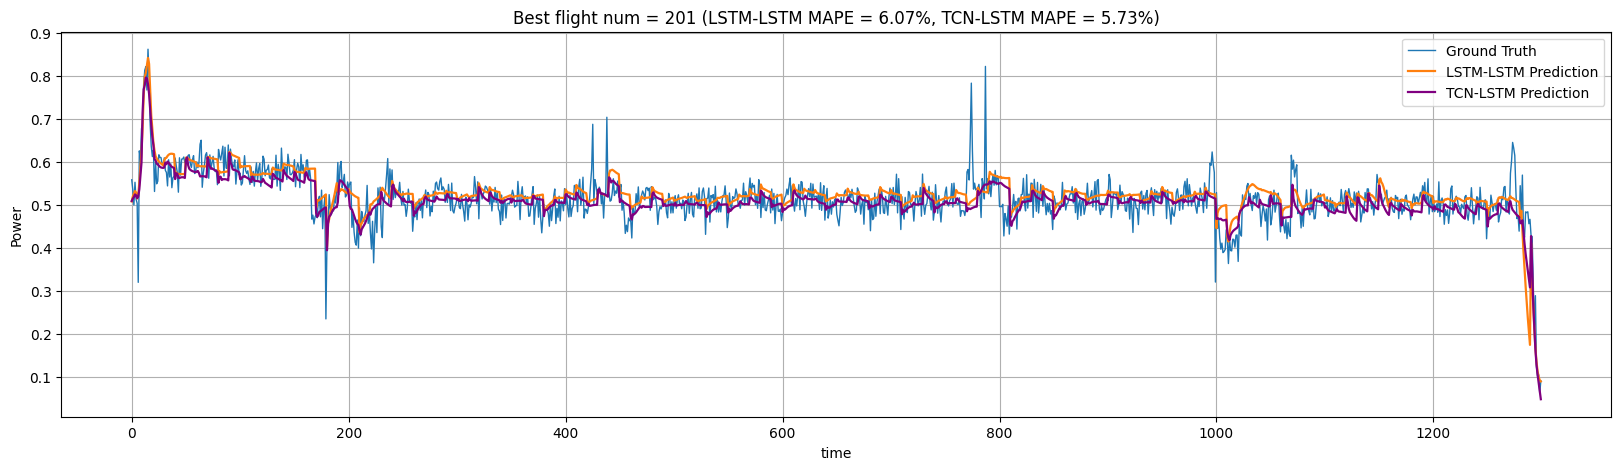

In [153]:
# plot the best flight

print(f'Best flight num = {best_flight_num}, MAPE = {best_flight_mape:.2f}%')

test_data = data[(data['flight'] == best_flight_num) & (data['power'] > 0.02)]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)
targets = output_seq.cpu().numpy()

lstm_lstm.eval()
with torch.no_grad():
    outputs1 = lstm_lstm(input_seq)  # No need for target length
    outputs1 = outputs1.squeeze(-1)  # Now [batch_size, 2]
    outputs1 = outputs1.cpu().numpy()

tcn_lstm.eval()
with torch.no_grad():
    outputs2 = tcn_lstm(input_seq)  # No need for target length
    outputs2 = outputs2.squeeze(-1)  # Now [batch_size, 2]
    outputs2 = outputs2.cpu().numpy()

mape1 = np.mean(np.abs((outputs1 - targets) / targets)) * 100
mape2 = np.mean(np.abs((outputs2 - targets) / targets)) * 100

gt_powers = []
pred_powers1 = []
pred_powers2 = []
for i in range(0, len(targets), output_len):
    gt_powers.extend(list(targets[i]))
    pred_powers1.extend(list(outputs1[i]))
    pred_powers2.extend(list(outputs2[i]))

plt.figure(figsize=(20, 5))
plt.plot(gt_powers, label='Ground Truth', linewidth=1)
plt.plot(pred_powers1, label='LSTM-LSTM Prediction', linewidth=1.6)
plt.plot(pred_powers2, label='TCN-LSTM Prediction', linewidth=1.6, color='purple')
plt.title(f'Best flight num = {best_flight_num} (LSTM-LSTM MAPE = {mape1:.2f}%, TCN-LSTM MAPE = {mape2:.2f}%)')
plt.xlabel('time')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.show()



Best flight num = 187, MAPE = 13.43%


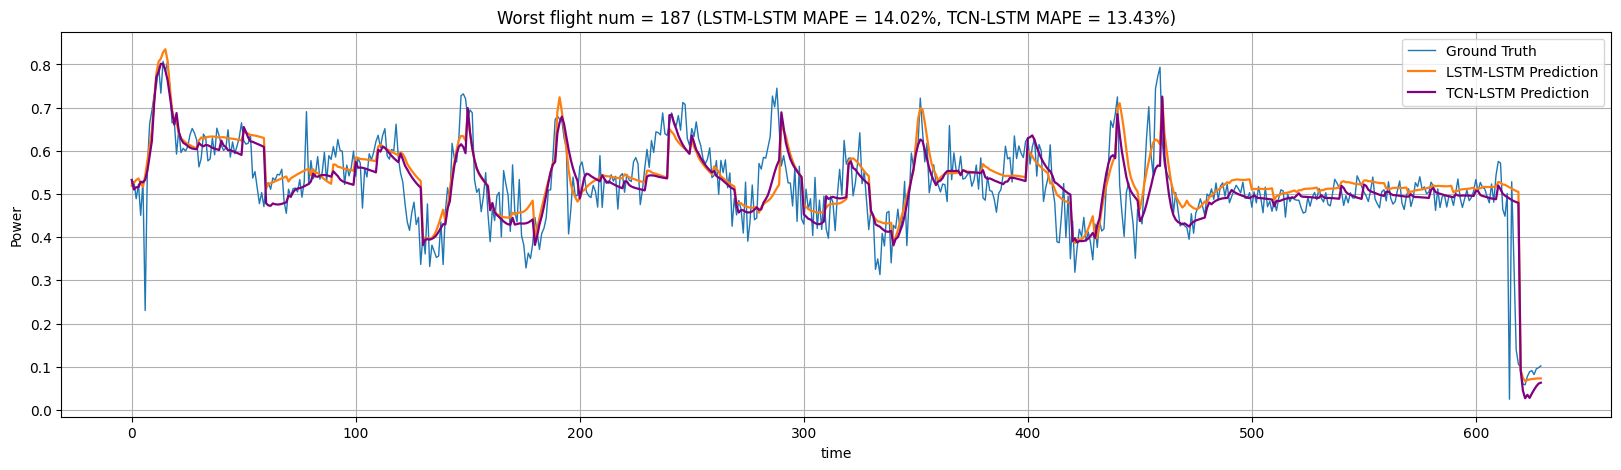

In [154]:
# plot the worst flight

print(f'Best flight num = {worst_flight_num}, MAPE = {worst_flight_mape:.2f}%')

test_data = data[(data['flight'] == worst_flight_num) & (data['power'] > 0.02)]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)
targets = output_seq.cpu().numpy()

lstm_lstm.eval()
with torch.no_grad():
    outputs1 = lstm_lstm(input_seq)  # No need for target length
    outputs1 = outputs1.squeeze(-1)  # Now [batch_size, 2]
    outputs1 = outputs1.cpu().numpy()

tcn_lstm.eval()
with torch.no_grad():
    outputs2 = tcn_lstm(input_seq)  # No need for target length
    outputs2 = outputs2.squeeze(-1)  # Now [batch_size, 2]
    outputs2 = outputs2.cpu().numpy()

mape1 = np.mean(np.abs((outputs1 - targets) / targets)) * 100
mape2 = np.mean(np.abs((outputs2 - targets) / targets)) * 100

gt_powers = []
pred_powers1 = []
pred_powers2 = []
for i in range(0, len(targets), output_len):
    gt_powers.extend(list(targets[i]))
    pred_powers1.extend(list(outputs1[i]))
    pred_powers2.extend(list(outputs2[i]))

plt.figure(figsize=(20, 5))
plt.plot(gt_powers, label='Ground Truth', linewidth=1)
plt.plot(pred_powers1, label='LSTM-LSTM Prediction', linewidth=1.6)
plt.plot(pred_powers2, label='TCN-LSTM Prediction', linewidth=1.6, color='purple')
plt.title(f'Worst flight num = {worst_flight_num} (LSTM-LSTM MAPE = {mape1:.2f}%, TCN-LSTM MAPE = {mape2:.2f}%)')
plt.xlabel('time')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.show()

## Scenarios with covariates

In [165]:
# Specify the input sequence length and output sequence length
input_len, output_len = 20, 

In [167]:
# Specify the features to be used
data = pd.read_csv('flights.csv')
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']

data, train_loader, val_loader, test_loader, d_split, scaler = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                                features=select_features, covariates=True)

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power', 'x_future', 'y_future', 'z_future', 'x_change', 'y_change', 'z_change']


### Models (without covariates)

In [168]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [169]:
# Model parameters
encoder_input_size = len(select_features)
decoder_input_size = encoder_input_size
covariates_size = 6 # [x, y, z, delta_x, delta_y, delta_z]
hidden_size = 32  
num_layers = 1

#### DeepTCN

In [170]:
from model.DeepTCN import DeepTCN

deepTCN = DeepTCN(num_series=encoder_input_size, num_blocks=3, 
                  kernel_size=3, hidden_channels=64, num_covariates=covariates_size).to(device)

pytorch_total_params = sum(p.numel() for p in deepTCN.parameters() if p.requires_grad)
print(pytorch_total_params)

73473


In [171]:
deepTCN.load_state_dict(torch.load(f'saved_model/DeepTCN_best_selected_model_{input_len}_{output_len}.pt'))

<All keys matched successfully>

#### LSTM_LSTM

In [172]:
from model.LSTM_LSTM import LSTM_LSTM

lstm_lstm = LSTM_LSTM(encoder_input_size, decoder_input_size, input_len, output_len, hidden_size, 
                      num_layers=num_layers, covariate=True, covariate_size=covariates_size).to(device)

pytorch_total_params = sum(p.numel() for p in lstm_lstm.parameters() if p.requires_grad)
print(pytorch_total_params)

10769


In [173]:
lstm_lstm.load_state_dict(torch.load(f'saved_model/LSTM_LSTM_covariate_select_best_model_{input_len}-{output_len}.pt'))

<All keys matched successfully>

#### TCN-LSTM

In [174]:
from model.TCN_LSTM import TCN_LSTM

tcn_lstm = TCN_LSTM(encoder_input_size, decoder_input_size, input_len, output_len, [32, 32], hidden_size, num_layers=num_layers, 
                    covariate=True, covariate_size=covariates_size).to(device)

pytorch_total_params = sum(p.numel() for p in tcn_lstm.parameters() if p.requires_grad)
print(pytorch_total_params)

13702


In [175]:
# Load saved model
tcn_lstm.load_state_dict(torch.load(f'saved_model/TCN_LSTM_covariate_select_best_model_{input_len}-{output_len}.pt'))

<All keys matched successfully>

### Test the model

In [178]:
deepTCN.name = 'DeepTCN'
for seq2seq in [deepTCN, lstm_lstm, tcn_lstm]:

    seq2seq.eval()
    sum_mape = 0
    sum_size = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        hist_inputs = inputs[:, :, :encoder_input_size].to(device)
        covariates = inputs[:, :output_len, encoder_input_size:].to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = seq2seq(hist_inputs, covariates)

        # print(r2_score(targets.cpu().T, outputs.cpu().T, multioutput='raw_values').shape)
        if len(outputs.shape) == 3:
            outputs = outputs.squeeze(-1)
        mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
        sum_mape += mape
        sum_size += targets.shape[0]*targets.shape[1]

    print(f"{seq2seq.name} test MAPE: {sum_mape/sum_size}")

DeepTCN test MAPE: 37.45165252685547
LSTM_LSTM test MAPE: 656.5739135742188
TCN_LSTM test MAPE: 756.0908813476562


In [ ]:
# reverse transform power prediction by scaler
power_idx = select_features.index('power')
power_min = scaler.data_min_[power_idx]
power_max = scaler.data_max_[power_idx]

print(power_min, power_max)

def scale_reverse(x):
    return x*(power_max - power_min) + power_min

In [ ]:


from data_process import create_sequences
from utils import plot_output

test_flights = d_split['test']

worst_flight_mape, worst_flight_num = 0, None
best_flight_mape, best_flight_num = np.inf, None

for seq2seq in ['naive', lstm_lstm, tcn_lstm]:
    
    sum_power_mape = 0
    sum_energy_mape = 0
    sum_size = 0

    for flight_num in test_flights:

        test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.02)]
        input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                                 test_data['power'].values, input_len, output_len)

        input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
        output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

        if seq2seq == 'naive':
            targets = output_seq
            targets = targets.cpu().numpy()
            outputs = test_data['power'].mean()*np.ones((targets.shape[0], targets.shape[1]))
        
        else:
            seq2seq.eval()
            with torch.no_grad():
                outputs = seq2seq(input_seq)  # No need for target length
                # Adjust the dimensions if necessary, based on your loss function requirements
                # Example: If your outputs and targets are both [batch_size, 2, 1]
                outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
                targets = output_seq
            outputs, targets = outputs.cpu().numpy(), targets.cpu().numpy()
        
            # find best and worst flight for TCN_LSTM
            if seq2seq.name == 'TCN_LSTM':
                mape = np.mean(np.abs((outputs - targets) / targets)) * 100
                if mape < best_flight_mape:
                    best_flight_mape = mape
                    best_flight_num = flight_num
                if mape > worst_flight_mape:
                    worst_flight_mape = mape
                    worst_flight_num = flight_num

        ape_power = np.sum(np.abs((outputs - targets) / targets)) * 100
        sum_power_mape += ape_power
        # plot_output(torch.tensor(outputs), torch.tensor(targets), output_len)
        
        unscaled_power_preds = scale_reverse(outputs)
        # print(unscaled_power_preds)
        hist_energy, future_dt_energy = create_sequences(test_data['energy_consumed_unscaled'].values, 
                                                        test_data[['time_diff_unscaled', 'energy_consumed_unscaled']].values, 
                                                        input_len, output_len)
        pred_energies = np.zeros((targets.shape[0], targets.shape[1]))
        prev_energy = hist_energy[:, -1]
        for t in range(targets.shape[1]):
            pred_energies[:, t] = prev_energy + unscaled_power_preds[:, t] * future_dt_energy[:, t, 0]
            prev_energy = pred_energies[:, t]
        target_energies = future_dt_energy[:, :, 1]
        ape_energy = np.sum(np.abs((pred_energies - target_energies) / target_energies)) * 100
        sum_energy_mape += ape_energy

        # plot_output(torch.tensor(pred_energies), torch.tensor(target_energies), output_len)
        sum_size += targets.shape[0] * targets.shape[1]

    if seq2seq == 'naive':
        print(f"{seq2seq} test power MAPE: {sum_power_mape/sum_size}")
        print(f"{seq2seq} test energy MAPE: {sum_energy_mape/sum_size}")
    else:
        print(f"{seq2seq.name} test power MAPE: {sum_power_mape/sum_size}")
        print(f"{seq2seq.name} test energy MAPE: {sum_energy_mape/sum_size}")
    print()